In [14]:
import numpy as np
from utils.algorithms import bresenham_line
from utils import overlay_image_with_blend, gaussian_kernel

In [38]:
def generate_parallel_or_perpendicular_lines(image_shape, num_lines=2):
    lines = []
    for _ in range(num_lines):
        # Elegir una orientación aleatoria (horizontal, vertical o diagonal)
        orientation = np.random.choice(['horizontal', 'vertical', 'diagonal'])
        
        # Generar los puntos de inicio y final seudoaleatorios
        if orientation == 'horizontal':
            y = np.random.randint(0, image_shape[0])  # Fijamos Y, aleatorio en X
            start = (0, y)
            end = (image_shape[1], y)
        elif orientation == 'vertical':
            x = np.random.randint(0, image_shape[1])  # Fijamos X, aleatorio en Y
            start = (x, 0)
            end = (x, image_shape[0])
        else:  # Diagonal
            x_start = np.random.randint(0, image_shape[1] // 2)
            y_start = np.random.randint(0, image_shape[0] // 2)
            start = (x_start, y_start)
            end = (image_shape[1] - x_start, image_shape[0] - y_start)
        
        # Agregar la línea generada
        line = bresenham_line(start=start, end=end)
        lines.append(line)
    
    return lines

def generate_image(shape_image_base=(512, 512), gaussian_size_low=4, gaussian_size_high=40, num_lines_range=(2, 6)):
    img, img_tmp = np.zeros(shape_image_base), np.zeros(shape_image_base)
    
    # Generar entre 2 y 6 líneas paralelas o perpendiculares
    num_lines = np.random.randint(num_lines_range[0], num_lines_range[1] + 1)
    lines = generate_parallel_or_perpendicular_lines(shape_image_base, num_lines)
    
    # Superponer las líneas en la imagen
    for line in lines:
        for point in line:
            random_size = np.random.randint(gaussian_size_low, gaussian_size_high)
            gaussian = gaussian_kernel(random_size)
            img += overlay_image_with_blend(img_tmp, gaussian, position=point)
    
    return img / np.max(img)  # Normalizar la imagen

# Uso de la función
img = generate_image(shape_image_base=(512, 512))

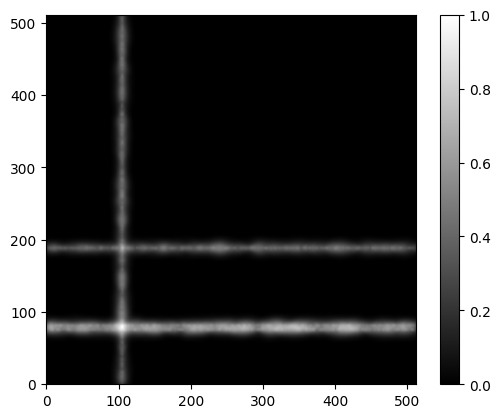

In [39]:

import matplotlib.pyplot as plt
plt.imshow(img, cmap='grey', origin='lower')
plt.colorbar()
plt.show()